In [1]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import glob
import re
import pandas as pd
import seaborn as sns
import math
from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from scipy.stats import ttest_ind
from io import StringIO
import os
import torch

RDKit WARNING: [21:32:17] Enabling RDKit 2020.03.1dev1 jupyter extensions


# Helper functions to be used throughout the analysis

In [3]:
def get_stats(pred, gold):
    rmse=np.sqrt(np.mean((pred-gold)**2))
    r2=np.corrcoef(pred,gold)[0][1]**2
    return(rmse,r2)

## Generating LaTeX for Table 1 and STable1

In [19]:
data=pd.read_csv('data/soltrannet_sweep_table.csv')

In [28]:
print(data.to_latex(columns=['Model','Parameters']+[x for x in data.columns.tolist() if 'RMSE' in x]))

\begin{tabular}{llrrrrrr}
\toprule
{} &    Model &  Parameters &  CCV RMSE &  Fold0 RMSE &  Fold1 RMSE &  Fold2 RMSE &  Ind RMSE \\
\midrule
0  &        0 &    21061633 &     1.449 &       1.161 &       1.959 &       1.054 &     1.914 \\
1  &        1 &      502529 &     1.467 &       1.231 &       1.972 &       1.028 &     1.946 \\
2  &        2 &      336385 &     1.377 &       1.260 &       1.682 &       1.126 &     1.870 \\
3  &        3 &      336385 &     1.454 &       1.239 &       1.857 &       1.165 &     1.949 \\
4  &        4 &       22657 &     1.297 &       1.187 &       1.582 &       1.066 &     1.903 \\
5  &        5 &       11905 &     1.271 &       1.130 &       1.605 &       0.998 &     1.923 \\
6  &        6 &       11905 &     1.350 &       1.272 &       1.680 &       1.012 &     1.903 \\
7  &        7 &        3393 &     1.459 &       1.172 &       1.916 &       1.159 &     1.779 \\
8  &        8 &        2609 &     1.376 &       1.169 &       1.788 &       1.055 &

In [31]:
print(data.to_latex(columns=['Model','Parameters']+[x for x in data.columns.tolist() if 'RMSE' not in x]))

\begin{tabular}{llrlrrrrrr}
\toprule
{} &    Model &  Parameters &    Model &  Parameters &  CCV \$R\textasciicircum 2\$ &  Fold0 \$R\textasciicircum 2\$ &  Fold1 \$R\textasciicircum 2\$ &  Fold2 \$R\textasciicircum 2\$ &  Ind \$R\textasciicircum 2\$ \\
\midrule
0  &        0 &    21061633 &        0 &    21061633 &     0.6700 &       0.7780 &       0.5200 &       0.7270 &     0.4718 \\
1  &        1 &      502529 &        1 &      502529 &     0.6620 &       0.7690 &       0.4650 &       0.7330 &     0.4576 \\
2  &        2 &      336385 &        2 &      336385 &     0.6930 &       0.7640 &       0.5630 &       0.7060 &     0.4890 \\
3  &        3 &      336385 &        3 &      336385 &     0.6720 &       0.7640 &       0.5390 &       0.6850 &     0.4461 \\
4  &        4 &       22657 &        4 &       22657 &     0.7240 &       0.7800 &       0.6260 &       0.7160 &     0.4831 \\
5  &        5 &       11905 &        5 &       11905 &     0.7230 &       0.7930 &       0.5950 &     

## Generating the data for Table 2 and SFigXX

In [35]:
#step 1 -- Generating the dictionary for the things
data={}
for dyn in range(1,21):
    data[dyn]={'R2':[],'RMSE':[],'ensR2':0,'ensRMSE':0}
    predfiles=glob.glob(f'data/predictions/final_model_ind_dyn{dyn}_*.predictions')
    
    preds=[]
    
    for f in predfiles:
        tmp=pd.read_csv(f)
        preds.append(tmp['pred'].to_list())
        g=np.array(tmp['true'].to_list())
        p=np.array(tmp['pred'].to_list())
        ccvRMSE,ccvR2=get_stats(g,p)
        data[dyn]['R2'].append(ccvR2)
        data[dyn]['RMSE'].append(ccvRMSE)
    
    ensemble_preds=np.array([np.mean([a,b,c,d,e]) for a,b,c,d,e in zip(*preds)])
    ensRMSE,ensR2=get_stats(g,ensemble_preds)
    data[dyn]['ensR2']=ensR2
    data[dyn]['ensRMSE']=ensRMSE

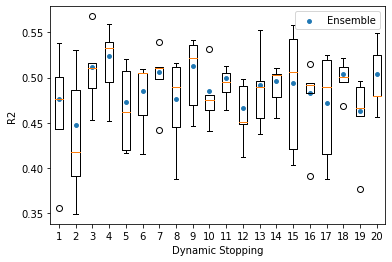

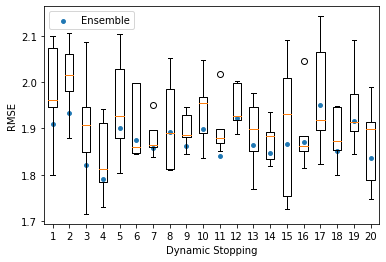

In [42]:
#step 2 -- Generating the Supplemental Figure
for thing in ['R2','RMSE']:
    xs=list(range(1,21))
    toplot=[]
    for x in xs:
        toplot.append(data[x][thing])
    
    ens_toplot=[]
    for x in xs:
        ens_toplot.append(data[x]['ens'+thing])
    
    fig=plt.figure()
    plt.boxplot(toplot)
    plt.scatter(xs,ens_toplot,s=15,label='Ensemble')
    plt.legend()
    plt.ylabel(thing)
    plt.xlabel('Dynamic Stopping')
    plt.savefig(f'figures/final_model_ind_dyn_{thing}.pdf')

In [39]:
#step 3 -- Generating the mean and standard deviation of the deployed model on the independent test set
predfiles=glob.glob("data/predictions/final_model_ind_dyn4_*.predictions")
bestRMSEmodel=""
bestR2model=""
bRMSE=99999
bR2=-1
rmses=[]
r2s=[]
for f in predfiles:
    tmp=pd.read_csv(f)
    preds.append(tmp['pred'].to_list())
    g=np.array(tmp['true'].to_list())
    p=np.array(tmp['pred'].to_list())
    ccvRMSE,ccvR2=get_stats(g,p)
    rmses.append(ccvRMSE)
    r2s.append(ccvR2)
    if ccvRMSE < bRMSE:
        bRMSE=ccvRMSE
        bestRMSEmodel=f
    if ccvR2 > bR2:
        bR2=ccvR2
        bestR2model=f
print(bRMSE,bestRMSEmodel)
print(bR2,bestR2model)

1.7298974639528197 data/predictions/final_model_ind_dyn4_s2.predictions
0.5596704947566871 data/predictions/final_model_ind_dyn4_s2.predictions


In [40]:
print(np.mean(rmses),np.std(rmses))
print(np.mean(r2s),np.std(r2s))

1.8360374383793598 0.07940531458138983
0.5157489148948112 0.038228455128320564


In [43]:
data[4]

{'R2': [0.4947262470095967,
  0.5332522416933896,
  0.45188156560998505,
  0.5596704947566871,
  0.5392140254043978],
 'RMSE': [1.9128052790850683,
  1.812051724198106,
  1.9413553473499459,
  1.7298974639528197,
  1.784077377310859],
 'ensR2': 0.5237005102474375,
 'ensRMSE': 1.7902392550016328}

In [48]:
#step 4 -- Generating the data for the training set
todo=glob.glob('data/training_data/final_model/*dyn4*testdic.pi')
rmses=[]
r2s=[]
for fname in todo:
    dic=pickle.load(open(fname,'rb'))
    rmses.append(dic['RMSE'])
    r2s.append(dic['R2'])
    if 'seed2' in fname:
        print(dic['RMSE'],dic['R2'])

1.1871270532481517 0.7644287801870121


In [49]:
print(np.mean(rmses),np.std(rmses))
print(np.mean(r2s),np.std(r2s))

1.2373119290478816 0.06962493570623078
0.7602940866772327 0.010218769621487935


## Generating the figures for 2D vs 3D embeddings of the molecule

In [68]:
# need 2D vs 3D plots & t-test for significance for the first 10 models.
def plotter(xlabel,ylabel,hue,dataframe,savename):
    fig=plt.figure()
    sns.boxplot(xlabel,ylabel,data=dataframe,color='w')
    a=sns.swarmplot(xlabel,ylabel,hue=hue,data=df)
    plt.legend(bbox_to_anchor=(1.05,1),loc=2)
    plt.tight_layout()
    plt.savefig(savename)

In [63]:
df=pd.read_csv('data/model_selection.csv')

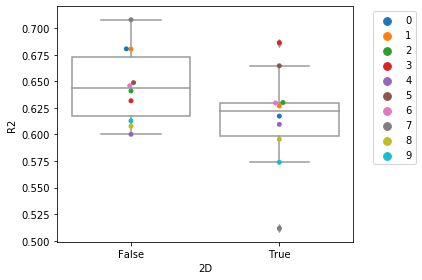

In [69]:
plotter('2D','R2','model',df,'figures/2dv3d_r2.pdf')

In [59]:
#T-Test for the above plot
ttest_ind(df[df['2D']==True]['R2'],df[df['2D']==False]['R2'])

Ttest_indResult(statistic=-1.6514130654734087, pvalue=0.11599231168237253)

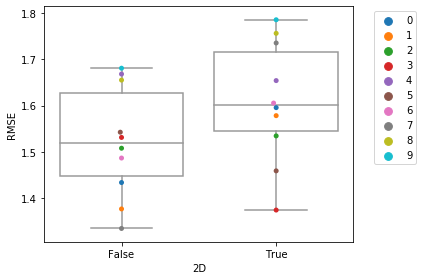

In [70]:
plotter('2D','RMSE','model',df,'figures/2dv3d_rmse.pdf')

In [66]:
#T-Test for the above plot
ttest_ind(df[df['2D']==True]['RMSE'],df[df['2D']==False]['RMSE'])

Ttest_indResult(statistic=1.528668871470288, pvalue=0.14372944251741623)

## Generating the figures for Fragmenting Salt analysis

In [153]:
basedirs=['final_model_full_saltfragafter','final_model_noothers_saltfragafter','final_model_others2plus_saltfragafter','final_model_othersMW_saltfragafter']
saltfrag_data={}
for d in basedirs:
    saltfrag_data[d]={}
    for thing in ['train_test','trainsalt_test','train_testsalt','trainsalt_testsalt']:
        saltfrag_data[d][thing]={'RMSEs':[],'R2s':[]}
        for seed in ['0','1','2','3','4']:
            preds=np.array([])
            golds=np.array([])

            #we are working with full ccv for training to predict the removed test set
            predfiles=glob.glob(f'data/predictions/{d}/*{thing}_s{seed}f*.predictions')
            for f in predfiles:
                tmp=pd.read_csv(f)
                g=np.array(tmp['true'].to_list())
                p=np.array(tmp['pred'].to_list())
                golds=np.append(golds,g)
                preds=np.append(preds,p)
            #now that we have the full preds and golds arrays we can calculate the R2 and RMSE
            ccvRMSE,ccvR2=get_stats(preds,golds)
            saltfrag_data[d][thing]['RMSEs'].append(ccvRMSE)
            saltfrag_data[d][thing]['R2s'].append(ccvR2) 

Full Aqsol Data R2s Ttest_indResult(statistic=2.193485970905479, pvalue=0.05959618679483788)
Full Aqsol Data R2s Ttest_indResult(statistic=-1.4496020124670779, pvalue=0.18521210985477343)
Full Aqsol Data RMSEs Ttest_indResult(statistic=0.39843371673204186, pvalue=0.7007329710106284)
Full Aqsol Data RMSEs Ttest_indResult(statistic=1.0367278229758816, pvalue=0.33018057273920526)
Aqsol Without Other typed molecules R2s Ttest_indResult(statistic=1.5682761197748385, pvalue=0.15545399812276248)
Aqsol Without Other typed molecules R2s Ttest_indResult(statistic=-3.2559355988055794, pvalue=0.011597594438225617)
Aqsol Without Other typed molecules RMSEs Ttest_indResult(statistic=-0.945887667575338, pvalue=0.371895084315655)
Aqsol Without Other typed molecules RMSEs Ttest_indResult(statistic=1.9676839728315882, pvalue=0.08464632784846389)
Aqsol Without 1 atom Other typed molecules R2s Ttest_indResult(statistic=2.7779296914994926, pvalue=0.024001116996338223)
Aqsol Without 1 atom Other typed molec

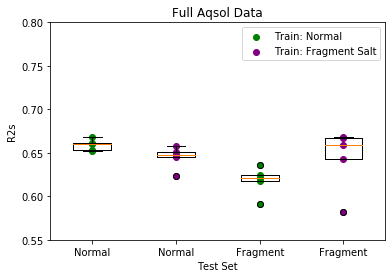

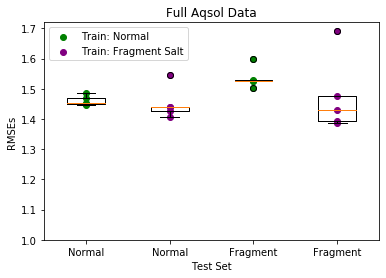

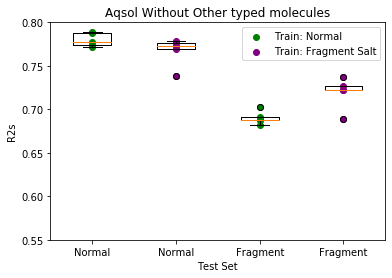

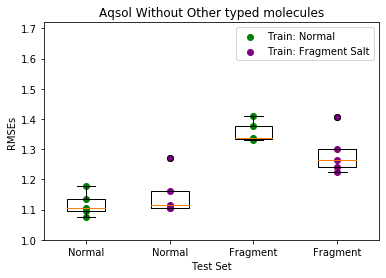

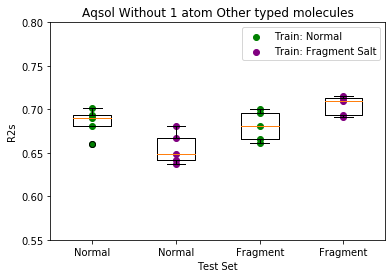

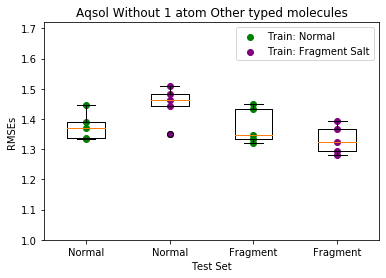

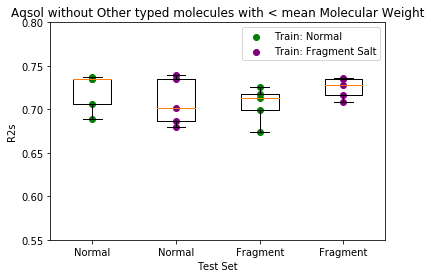

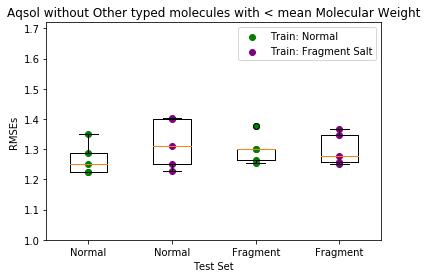

In [154]:
lookup_titles={
    'final_model_full_saltfragafter':'Full Aqsol Data',
    'final_model_noothers_saltfragafter':'Aqsol Without Other typed molecules',
    'final_model_others2plus_saltfragafter':'Aqsol Without 1 atom Other typed molecules',
    'final_model_othersMW_saltfragafter':'Aqsol without Other typed molecules with < mean Molecular Weight'
}

color_lookup={0:'purple',1:'green'}
label_lookup={
    0:'Train: Fragment Salt',
    1:'Train: Normal',
}
for d in basedirs:
    for thing in ['R2s','RMSEs']:
        fig,ax=plt.subplots()
        toplot=[]
        labels=['train_test','trainSF_test','train_testSF','trainSF_testSF']
        for x in labels:
            toplot.append(saltfrag_data[d][x.replace('SF','salt')][thing])
        ax.boxplot(toplot)
        
        x=1
        for item in [[toplot[0],toplot[2]],[toplot[1],toplot[3]]]:
            ax.scatter([[x,x,x,x,x],[x+2,x+2,x+2,x+2,x+2]],item,label=label_lookup[x%2],color=color_lookup[x%2])
            x+=1
        #plt.scatter([[1,1,1,1,1],[2,2,2,2,2],[3,3,3,3,3],[4,4,4,4,4]],toplot,label=['Train: Salts','Train: Fragmented Salt','Train: Salts','Train: Fragmented Salt'],color=plot_colors)
        plt.xticks([1,2,3,4],['Normal','Normal','Fragment','Fragment'])
        plt.title(lookup_titles[d])
        if thing=='RMSEs':
            plt.ylim((1.0,1.72))
        else:
            plt.ylim((0.55,0.80))
        plt.ylabel(thing)
        plt.legend()
        plt.xlabel('Test Set')
        plt.savefig(f'figures/{d.split("_")[-2]}_saltfragfirst_{thing}_boxplots.pdf')
        
        print(f'{lookup_titles[d]} {thing} {ttest_ind(toplot[0],toplot[1])}')
        print(f'{lookup_titles[d]} {thing} {ttest_ind(toplot[2],toplot[3])}')

## Generating the timing analysis here

In [4]:
os.chdir('src')
from data_utils import load_data_from_df as load_df_gpu
from data_utils import construct_loader as construct_loader_gpu
from data_utils import load_data_from_smiles as load_smiles_gpu

from cpu_data_utils import load_data_from_df as load_df_cpu
from cpu_data_utils import construct_loader as construct_loader_cpu
from cpu_data_utils import load_data_from_smiles as load_smiles_cpu

from transformer import make_model
import time

In [5]:
def complex_measure(model,list_of_smiles,two_d=False,model_cpu=False):
    '''
    A more complicated measure of the forward-pass.
    
    This function takes in a list of smile strings, then will create the needed molecular graphs & run the forward-pass
    
    Assumes the model is in evaluate mode
    '''
    t0=time.time()
    ls=[0.0 for x in list_of_smiles]
    t1=time.time()
    if model_cpu:
        X,y=load_smiles_cpu(list_of_smiles,ls,add_dummy_node=True,one_hot_formal_charge=True,two_d_only=two_d)
    else:
        X,y=load_smiles_gpu(list_of_smiles,ls,add_dummy_node=True,one_hot_formal_charge=True,two_d_only=two_d)
    tload=time.time()-t1
    if model_cpu:
        data_loader=construct_loader_cpu(X,y,1)
    else:
        data_loader=construct_loader_gpu(X,y,1)
    for batch in data_loader:
        adjacency_matrix, node_features, distance_matrix, y = batch
        batch_mask = torch.sum(torch.abs(node_features), dim=-1) != 0
        y_pred = model(node_features, batch_mask, adjacency_matrix, distance_matrix, None)
    elapsed_fp=time.time()-t0
    return elapsed_fp,tload

In [6]:
#making the original MAT implementation -- GPU
d_atom=28
mat_model_params = {
    'd_atom': d_atom,
    'd_model': 1024,
    'N': 8,
    'h': 16,
    'N_dense': 1,
    'lambda_attention': 0.33, 
    'lambda_distance': 0.33,
    'leaky_relu_slope': 0.1, 
    'dense_output_nonlinearity': 'relu', 
    'distance_matrix_kernel': 'exp', 
    'dropout': 0.0,
    'aggregation_type': 'mean'
}

stn_model_params = {
    'd_atom': d_atom,
    'd_model': 8,
    'N': 8,
    'h': 2,
    'N_dense': 1,
    'lambda_attention': 0.5, 
    'lambda_distance': 0.0,
    'leaky_relu_slope': 0.1, 
    'dense_output_nonlinearity': 'relu', 
    'distance_matrix_kernel': 'exp', 
    'dropout': 0.1,
    'aggregation_type': 'mean'
}

mat_gpu=make_model(**mat_model_params)

mat_gpu.to('cuda')

GraphTransformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
            (1): Linear(in_features=1024, out_features=1024, bias=True)
            (2): Linear(in_features=1024, out_features=1024, bias=True)
            (3): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): ModuleList(
            (0): Dropout(p=0.0, inplace=False)
          )
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (1): SublayerConnection(
     

In [7]:
stn_gpu=make_model(**stn_model_params)
stn_gpu.to('cuda')

GraphTransformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
            (2): Linear(in_features=8, out_features=8, bias=True)
            (3): Linear(in_features=8, out_features=8, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (linears): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
          )
          (dropout): ModuleList(
            (0): Dropout(p=0.1, inplace=False)
          )
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
   

In [8]:
smis=open('../data/llinas2020/llinas2020_raw.csv').readlines()
smis=[x.split(',')[-1].rstrip() for x in smis[1:]]

In [10]:
mat_gpu_times_2d=[]
mat_gpu_times_3d=[]
stn_gpu_times_2d=[]
stn_gpu_times_3d=[]
for s in smis:
    mat_gpu_times_2d.append(complex_measure(mat_gpu,[s],two_d=True))
    mat_gpu_times_3d.append(complex_measure(mat_gpu,[s],two_d=False))
    stn_gpu_times_2d.append(complex_measure(stn_gpu,[s],two_d=True))
    stn_gpu_times_3d.append(complex_measure(stn_gpu,[s],two_d=False))

In [11]:
#plotting the length sorted version of the one we did.
print(f'MAT GPU - 2D {np.mean([x[0] for x in mat_gpu_times_2d])} s per molecule')
print(f'MAT GPU - 3D {np.mean([x[0] for x in mat_gpu_times_3d])} s per molecule')
print(f'STN GPU - 2D {np.mean([x[0] for x in stn_gpu_times_2d])} s per molecule')
print(f'STN GPU - 3D {np.mean([x[0] for x in stn_gpu_times_3d])} s per molecule')

MAT GPU - 2D 0.02151161071025964 s per molecule
MAT GPU - 3D 0.139426897872578 s per molecule
STN GPU - 2D 0.022470958305127693 s per molecule
STN GPU - 3D 0.1367122603185249 s per molecule


In [12]:
#doing the same analysis as above, but on CPU
mat_cpu=make_model(**mat_model_params)
mat_cpu.to('cpu')

GraphTransformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
            (1): Linear(in_features=1024, out_features=1024, bias=True)
            (2): Linear(in_features=1024, out_features=1024, bias=True)
            (3): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): ModuleList(
            (0): Dropout(p=0.0, inplace=False)
          )
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (1): SublayerConnection(
     

In [13]:
stn_cpu=make_model(**stn_model_params)
stn_cpu.to('cpu')

GraphTransformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
            (2): Linear(in_features=8, out_features=8, bias=True)
            (3): Linear(in_features=8, out_features=8, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (linears): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
          )
          (dropout): ModuleList(
            (0): Dropout(p=0.1, inplace=False)
          )
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
   

In [14]:
mat_cpu_times_2d=[]
mat_cpu_times_3d=[]
stn_cpu_times_2d=[]
stn_cpu_times_3d=[]
for s in smis:
    mat_cpu_times_2d.append(complex_measure(mat_cpu,[s],two_d=True,model_cpu=True))
    mat_cpu_times_3d.append(complex_measure(mat_cpu,[s],two_d=False,model_cpu=True))
    stn_cpu_times_2d.append(complex_measure(stn_cpu,[s],two_d=True,model_cpu=True))
    stn_cpu_times_3d.append(complex_measure(stn_cpu,[s],two_d=False,model_cpu=True))

In [15]:
#plotting the length sorted version of the one we did.
print(f'MAT CPU - 2D {np.mean([x[0] for x in mat_cpu_times_2d])} s per molecule')
print(f'MAT CPU - 3D {np.mean([x[0] for x in mat_cpu_times_3d])} s per molecule')
print(f'STN CPU - 2D {np.mean([x[0] for x in stn_cpu_times_2d])} s per molecule')
print(f'STN CPU - 3D {np.mean([x[0] for x in stn_cpu_times_3d])} s per molecule')

MAT CPU - 2D 0.03947355169238466 s per molecule
MAT CPU - 3D 0.15999577262184836 s per molecule
STN CPU - 2D 0.017622631607633648 s per molecule
STN CPU - 3D 0.13685045278433597 s per molecule


## Generating the Latex for the performance on multiple test sets

In [12]:
#calculating the means and standard deviations for the table
def helper(filename):
    tmp=pickle.load(open(filename,'rb'))
    return tmp['R2'],tmp['RMSE']

def helper2(filename):
    tmp=pd.read_csv(filename)
    gold=np.array(tmp['true'].to_list())
    pred=np.array(tmp['pred'].to_list())
    ccvRMSE,ccvR2=get_stats(gold,pred)
    return ccvR2, ccvRMSE

#Cui et all 2020
todo=glob.glob('data/cui2020/*testdic.pi')
r2s=[]
rmses=[]
for fname in todo:
    r2,rmse=helper(fname)
    r2s.append(r2)
    rmses.append(rmse)
print(f'Cui2020 Training R2:{np.mean(r2s)},{np.std(r2s)}  RMSE:{np.mean(rmses)},{np.std(rmses)}')

#Boobier et al 2017
todo=glob.glob('data/boobier2017/*testdic.pi')
r2s=[]
rmses=[]
for fname in todo:
    r2,rmse=helper(fname)
    r2s.append(r2)
    rmses.append(rmse)
print(f'Boobier2017 R2:{np.mean(r2s)},{np.std(r2s)}  RMSE:{np.mean(rmses)},{np.std(rmses)}')

#Louvric et al 2020
for key in ['1000epochs','final_aq_model']:
    todo=glob.glob('data/louvric2020/*'+key+'*.predictions')
    r2s=[]
    rmses=[]
    for fname in todo:
        r2,rmse=helper2(fname)
        r2s.append(r2)
        rmses.append(rmse)
    print(f'Louvric2020 Training {key} Training R2:{np.mean(r2s)},{np.std(r2s)}  RMSE:{np.mean(rmses)},{np.std(rmses)}')

#LLinas et al 2020
for key in ['llinas_set1','llinas_set2']:
    todo=glob.glob(f'data/llinas2020/soltrannet/{key}*testdic.pi')
    r2s=[]
    rmses=[]
    for fname in todo:
        r2,rmse=helper(fname)
        r2s.append(r2)
        rmses.append(rmse)
    print(f'LLinas2020 {key} Training R2:{np.mean(r2s)},{np.std(r2s)}  RMSE:{np.mean(rmses)},{np.std(rmses)}')

Cui2020 Training R2:0.5601740099806233,0.03128221942074987  RMSE:0.7493463709134435,0.12960915284753105
Boobier2017 R2:0.5432285946421288,0.1424843888425703  RMSE:1.2739101709030884,0.1775665240747097
Louvric2020 Training 1000epochs Training R2:0.709438949167738,0.053656809968186156  RMSE:0.8979027406547612,0.10091079505030429
Louvric2020 Training final_aq_model Training R2:0.7117037654597491,0.032691719047060315  RMSE:1.0314371940305525,0.06931176030697704
LLinas2020 llinas_set1 Training R2:0.45372183414693534,0.019808754714666296  RMSE:1.4208055173003435,0.2041449451263055
LLinas2020 llinas_set2 Training R2:0.7395709358690792,0.0172558025187511  RMSE:1.619194489094643,0.38049062764873726


In [13]:
data=pd.read_csv('data/soltrannet_othersets.csv')
data.columns

Index(['Dataset', 'Reported R2', 'Reported RMSE', 'SolTranNet Training R2',
       'SolTranNet Best R2', 'SolTranNet Deployed R2',
       'SolTranNet Training RMSE', 'SolTranNet Best RMSE',
       'SolTranNet Deployed RMSE', 'Deployed Training Overlap'],
      dtype='object')

In [17]:
print(data.to_latex(columns=['Dataset']+[x for x in data.columns.tolist() if 'RMSE' in x]+['Deployed Training Overlap']))

\begin{tabular}{llllrll}
\toprule
{} &                 Dataset & Reported RMSE & SolTranNet Training RMSE &  SolTranNet Best RMSE & SolTranNet Deployed RMSE & Deployed Training Overlap \\
\midrule
0 &          Cui et al 2020 &         0.681 &             0.749(0.130) &                 0.634 &                    0.704 &                      0/62 \\
1 &      Boobier et al 2017 &  0.543(0.142) &                     1.01 &                 1.119 &                    23/25 &                       NaN \\
2 &      Louvric et al 2020 &          0.72 &             0.898(0.101) &                 0.720 &            1.031(0.0693) &          151.4(3.382)/166 \\
3 &  Llinas et al 2020 set1 &          0.78 &             1.421(0.204) &                 1.055 &                    1.301 &                    79/100 \\
4 &  LLinas et al 2020 set2 &          1.06 &             1.619(0.380) &                 1.229 &                    1.729 &                     18/32 \\
\bottomrule
\end{tabular}



In [18]:
print(data.to_latex(columns=['Dataset']+[x for x in data.columns.tolist() if 'R2' in x]+['Deployed Training Overlap']))

\begin{tabular}{llllrll}
\toprule
{} &                 Dataset &  Reported R2 & SolTranNet Training R2 &  SolTranNet Best R2 & SolTranNet Deployed R2 & Deployed Training Overlap \\
\midrule
0 &          Cui et al 2020 &        0.412 &          0.560(0.0313) &               0.604 &                  0.650 &                      0/62 \\
1 &      Boobier et al 2017 &  0.706.0.985 &                  0.724 &               0.672 &           1.274(0.178) &                       NaN \\
2 &      Louvric et al 2020 &           -- &          0.709(0.0537) &               0.783 &          0.712(0.0327) &          151.4(3.382)/166 \\
3 &  Llinas et al 2020 set1 &         0.62 &          0.454(0.0198) &               0.478 &                  0.511 &                    79/100 \\
4 &  LLinas et al 2020 set2 &         0.75 &          0.740(0.0172) &               0.770 &                  0.720 &                     18/32 \\
\bottomrule
\end{tabular}



## Generating the plots for the "slicing analysis"?

In [183]:
def calc_stats(pred_array, true_array, insol_thresh=-6, lower_sol_thresh=-4, upper_sol_thresh=100000):
    '''
    This function will calculate the following on the predicted array:
        Hit% = #correct(lower_sol_thresh,upper_sol_thresh) / #(lower_sol_thresh,upper_sol_thresh)
        Fail% = #true(insol_thresh)pred(lower_sol_thresh,upper_sol_thresh) / #pred(lower_sol_thresh,upper_sol_thresh)
    
    Assumptions: pred_array,true_array are paired numpy arrays.
    '''
    
    #first we need to access the examples which have true in (lower_sol_thresh, upper_sol_thresh)
    true_mask=(true_array > lower_sol_thresh)&(true_array<upper_sol_thresh)
    
    #calculating the Hit%
    num_true=len(true_array[true_mask])
    poss_hits=pred_array[true_mask]
    num_hits=np.sum((poss_hits>lower_sol_thresh)&(poss_hits<upper_sol_thresh))
    hit=num_hits/float(num_true)
    
    #calculating the Fail%
    pred_mask=(pred_array > lower_sol_thresh)&(pred_array<upper_sol_thresh)
    insol_mask=true_array <= insol_thresh
    fail=np.sum(insol_mask & pred_mask) / float(np.sum(pred_mask))
    
    #calculating the Miss%
    miss=1-hit
    
    return hit,fail,np.sum(true_mask),np.sum(pred_mask)

In [184]:
calc_stats(deployed_pred,deployed_true)

(0.9791666666666666, 0.0375, 48, 80)

In [185]:
data={'hit':[],'fail':[]}

#adding the SolTranNet data
truths=np.array([])
preds=np.array([])
for s in ['set1','set2']:
    tmp=pd.read_csv(f'data/llinas2020/soltrannet/llinas_{s}_final_aq_model.predictions')
    t=tmp['true']
    truths=np.append(truths,t)
    p=tmp['pred']
    preds=np.append(preds,p)
hit,fail,nt,npred=calc_stats(preds,truths)
data['hit'].append(('SolTranNet',hit))
data['fail'].append(('SolTranNet',fail))

In [186]:
np.mean(truths)

-4.321439393939395

(array([ 1.,  2.,  1.,  5., 13., 21., 32., 34., 10., 13.]),
 array([-10.4  ,  -9.478,  -8.556,  -7.634,  -6.712,  -5.79 ,  -4.868,
         -3.946,  -3.024,  -2.102,  -1.18 ]),
 <a list of 10 Patch objects>)

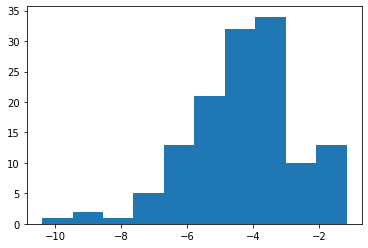

In [187]:
plt.hist(truths)

In [188]:
all_files=glob.glob('data/llinas2020/submitted/*.csv')
keys=set([x.split('/')[-1].split('_set')[0] for x in all_files])
for k in keys:
    truths=np.array([])
    preds=np.array([])
    todo=glob.glob(f'data/llinas2020/submitted/{k}*.csv')
    for fname in todo:
        tmp=pd.read_csv(fname)
        t=tmp['TRUE']
        truths=np.append(truths,t)
        p=tmp['PREDICTED']
        preds=np.append(preds,p)
    hit,fail,nt,npred=calc_stats(preds,truths)
    if np.isnan(hit):
        print(f'{k} hit is nan')
    else:
        data['hit'].append((k,hit))
    
    if np.isnan(fail):
        print(f'{k} fail is nan')
    else:
        data['fail'].append((k,fail))

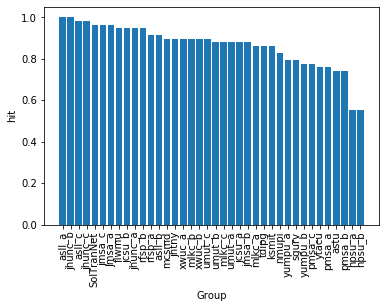

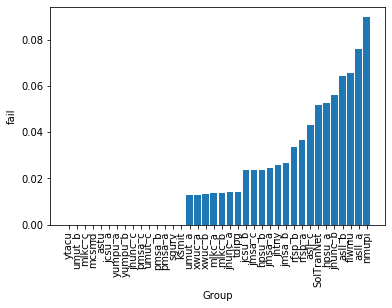

In [189]:
for k in data:
    fig=plt.figure()
    if k=='hit':
        all_data=sorted(data[k],key=lambda x:x[1],reverse=True)
    else:
        all_data=sorted(data[k],key=lambda x:x[1])
    
    labels=[x[0] for x in all_data]
    ys=[x[1] for x in all_data]
    x_pos=[i for i,_ in enumerate(all_data)]
    
    plt.bar(x_pos,ys)
    plt.xlabel('Group')
    plt.ylabel(k)
    plt.xticks(x_pos,labels,rotation='vertical')